In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import random
from sklearn.model_selection import train_test_split
import cv2 
import pywt

Cleaning

In [2]:
df=pd.read_csv('datasets/utkface_sortAge.csv')
df=df.drop(['ethnicity','Unnamed: 0'],axis='columns')
df.head()

,age,gender,image
0,1,1,109 146 198 132 169 221 134 171 223 137 174 22...
1,1,0,0 1 2 2 1 1 5 1 0 11 3 3 1 0 6 27 35 45 97 111...
2,1,0,54 64 91 55 66 95 56 72 105 58 76 113 67 85 12...
3,1,0,80 98 125 77 94 129 113 131 169 147 169 201 16...
4,1,0,63 55 96 58 51 94 72 67 112 83 80 126 91 90 13...


In [3]:
df1=df.copy()
df1['image']=df['image'].apply(lambda x: np.array(x.split(' '),dtype='int'))
df1.head()

,age,gender,image
0,1,1,"[109, 146, 198, 132, 169, 221, 134, 171, 223, ..."
1,1,0,"[0, 1, 2, 2, 1, 1, 5, 1, 0, 11, 3, 3, 1, 0, 6,..."
2,1,0,"[54, 64, 91, 55, 66, 95, 56, 72, 105, 58, 76, ..."
3,1,0,"[80, 98, 125, 77, 94, 129, 113, 131, 169, 147,..."
4,1,0,"[63, 55, 96, 58, 51, 94, 72, 67, 112, 83, 80, ..."


In [4]:
max(df1['age'])

116

Visualization

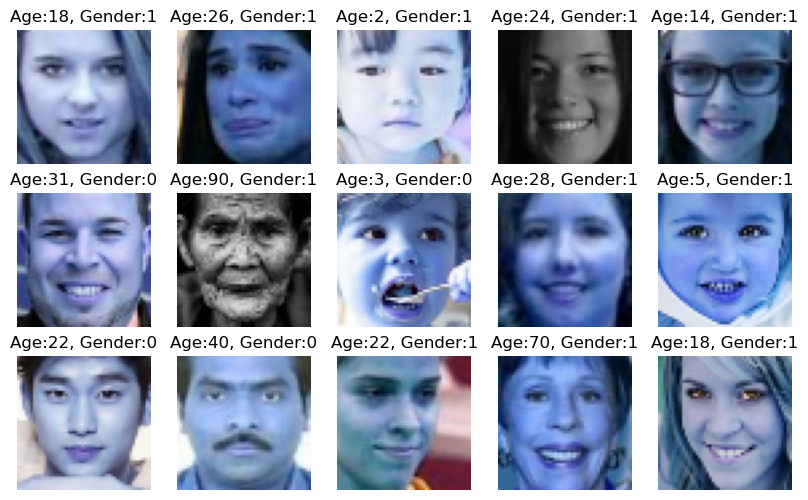

In [5]:
# creating an empty 3x3 subplot
fig, ax = plt.subplots(3, 5, figsize=(10, 6))
ax = ax.ravel()
 
# generating a random list of integers
res = random.sample(range(0, df1.shape[0]), 15)
 
# creating the subplot for random images and printing the corresponding gender and age
for i, id in enumerate(res):
    ax[i].imshow(df1['image'].loc[id].reshape(50, 50,3),cmap='gray')
    ax[i].set_title(f'Age:{df1.age.loc[id]}, Gender:{df.gender.loc[id]}')
    ax[i].axis('off')
plt.savefig('image_visualization_subplot.png')

Wavelet Transformation

In [6]:
X=df1['image']
y=df1['age']

In [7]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    # imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

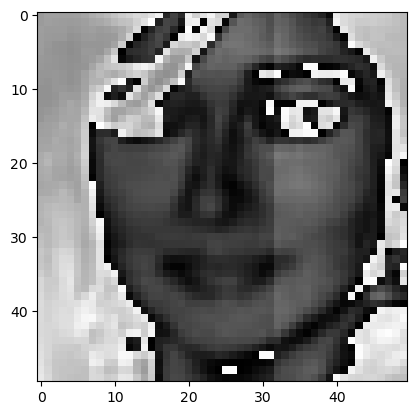

In [8]:
img=X[10000].reshape(50,50,3)[:,:,0]
w_img=w2d(img,'db1',5)
plt.imshow(w_img,cmap='gray')

In [9]:
X_wavelets=[]
for img in X:
    res_img=img.reshape(50,50,3)[:,:,0]
    w_img=w2d(res_img,'db1',5)
    X_wavelets.append(w_img)

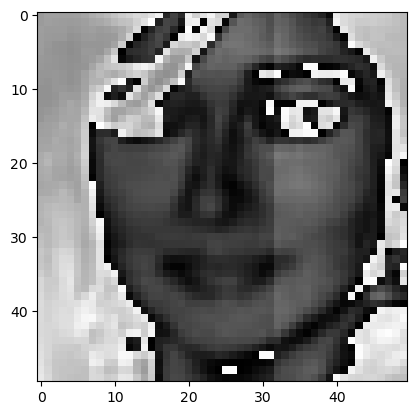

In [10]:
plt.imshow(X_wavelets[10000],cmap='gray')

Creating Tensor And Models

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
from torch.utils.data import DataLoader, TensorDataset

d:\Libraries\miniconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
d:\Libraries\miniconda3\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning 

In [12]:
X_tensor=torch.Tensor(X_wavelets)
y_tensor=torch.Tensor(y)
X_tensor1=X_tensor.reshape(-1,1,50,50)
y_tensor=y_tensor.type(torch.long)

C:\Users\doffy\AppData\Local\Temp\ipykernel_1832\2590541247.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)
  X_tensor=torch.Tensor(X_wavelets)


In [13]:
# y_tensor=y_tensor.reshape(-1,1)
X_tensor1.shape,y_tensor.shape

(torch.Size([23708, 1, 50, 50]), torch.Size([23708]))

In [14]:
device='cuda'

In [15]:
model=nn.Sequential(
    nn.Conv2d(1,32,kernel_size=3),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(32,64,kernel_size=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(64,128,kernel_size=3),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(128,256,kernel_size=3),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(0.2),
  
    nn.Flatten(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,117)
).to(device)
loss=nn.CrossEntropyLoss()
opt=optim.Adam(model.parameters(),lr=0.003)

Training the model with all available values better if you do train test split

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X_tensor1,y_tensor,test_size=0.1)

In [17]:
transform = v2.Compose([
    v2.RandomRotation(degrees=15), 
    v2.RandomHorizontalFlip(p=0.5),  
    v2.RandomCrop(40,4)   
])

In [18]:
train_dataset = TensorDataset(X_train, y_train)
train_dataset.transform=transform
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataset.transform=transform
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=True)

In [19]:
n_epochs = 60

for epoch in range(n_epochs):
    model.train()  # Set the model to training mode
    
    # Iterate over the batches
    for inputs, labels in train_loader:
        # Move batch tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss_value = loss(outputs, labels)

        # Backward pass
        opt.zero_grad()
        loss_value.backward()
        
        # Update parameters
        opt.step()
    
    # Print loss after each epoch
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss_value.item()}")

print("Training complete.")

Epoch [1/60], Loss: 3.6207032203674316
Epoch [2/60], Loss: 3.4720096588134766
Epoch [3/60], Loss: 3.779618501663208
Epoch [4/60], Loss: 3.4588100910186768
Epoch [5/60], Loss: 3.292677879333496
Epoch [6/60], Loss: 3.910886287689209
Epoch [7/60], Loss: 3.278120517730713
Epoch [8/60], Loss: 3.4247055053710938
Epoch [9/60], Loss: 2.5059587955474854
Epoch [10/60], Loss: 2.322014808654785
Epoch [11/60], Loss: 2.1822545528411865
Epoch [12/60], Loss: 2.300529718399048
Epoch [13/60], Loss: 1.9610916376113892
Epoch [14/60], Loss: 2.379178524017334
Epoch [15/60], Loss: 1.3829861879348755
Epoch [16/60], Loss: 2.092313766479492
Epoch [17/60], Loss: 1.3984756469726562
Epoch [18/60], Loss: 1.8752071857452393
Epoch [19/60], Loss: 1.823395848274231
Epoch [20/60], Loss: 1.3543634414672852
Epoch [21/60], Loss: 1.2406293153762817
Epoch [22/60], Loss: 1.2934014797210693
Epoch [23/60], Loss: 1.2419273853302002
Epoch [24/60], Loss: 1.7955958843231201
Epoch [25/60], Loss: 1.0810092687606812
Epoch [26/60], Los

In [31]:
correct = 0
total = 0
ac=0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _,predicted = torch.max(outputs, 1)  # Get the predicted class indices
        total += labels.size(0)  # Increment the total count by the batch size
        correct += (predicted == labels).sum().item()  # Count the number of correct predictions
        for i,j in zip(outputs,labels):
            if(torch.argmax(i)>j-5 and torch.argmax(i)<j+5):
                ac+=1
print(ac/total)
# Calculate accuracy
accuracy = correct / total
print(f"Accuracy: {100 * accuracy:.2f}%")

0.4280894137494728
Accuracy: 10.80%


In [21]:
test_img=test_dataset[1004][0].to(device)
test_label=test_dataset[1004][1]

In [22]:
test_label

tensor(39)

In [23]:
op=model(test_img.unsqueeze(0))

In [24]:
torch.argmax(op)

tensor(32, device='cuda:0')

In [25]:
model.eval()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Dropout(p=

In [26]:
torch.save(model,'models/entire_model_wavelet')

In [27]:
m1=torch.load('models/entire_model_wavelet')
m1.eval()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Dropout(p=